# Dimensionless caracterization of turbulent scales in microturbulent flow

This notebook aims at giving approximate values for temporal and spatial turbulences in a microconfined turbulent flow for different fluids. It is based on the RHEA solver (L. Jofre, A. Abdellatif, G. Oyarzun, (2023). RHEA: an open-source Reproducible Hybrid-architecture flow solver Engineered for Academia. Journal of Open Source Software, 8(81), 4637)

# Functions


## Library imports

In [234]:
import numpy as np
import copy
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors

## Helper functions

In [235]:
def list_generator(Value_min, Value_max, Number_of_points = 1000):
    """
    Generate a list of equally spaced values ranging from Value_min to Value_max.

    Parameters:
        Value_min (float): Minimum value.
        Value_max (float): Maximum value.
        Number_of_points (int): Number of points to generate. Default is 1000.

    Returns:
        numpy.ndarray: Array of equally spaced values.
    """
    return np.linspace(Value_min, Value_max, Number_of_points)

## Dimensionless numbers computation functions

In [236]:
def calculate_reynolds_number(U, L, nu):
    """
    Calculate the Reynolds number for a given flow.

    Args:
        U (float): Velocity of the flow (in m/s).
        L (float): Characteristic length (in meters).
        nu (float): Kinematic viscosity (in m^2/s).

    Returns:
        float: The Reynolds number.

    """
    # Calculate the Reynolds number using the formula: Re = (U * L) / nu
    Re = (U * L) / nu

    # Return the Reynolds number
    return Re

def calculate_eckert_number(U, c_p, T):
    """
    Calculate the Eckert number for a given flow. Here we approximate delta_T as T_bulk, denoted here by T

    Args:
        U (float): Velocity of the flow (in m/s).
        c_p (float): Specific heat capacity at constant pressure (in J/(kg*K)).
        delta_T (float): Temperature difference (in K).

    Returns:
        float: The Eckert number.

    """
    # Calculate the Eckert number using the formula: Ec = U^2 / (c_p * T)
    Ec = (U ** 2) / (c_p * T)

    # Return the Eckert number
    return Ec

def calculate_prandtl_number(mu, c_p, kappa):
    """
    Calculate the Prandtl number for a given fluid.

    Args:
        mu (float): Dynamic viscosity of the fluid (in kg/(m*s)).
        c_p (float): Specific heat capacity at constant pressure (in J/(kg*K)).
        kappa (float): Thermal conductivity of the fluid (in W/(m*K)).

    Returns:
        float: The Prandtl number.

    """
    # Calculate the Prandtl number using the formula: Pr = mu * c_p / kappa
    Pr = mu * c_p / kappa

    # Return the Prandtl number
    return Pr

def calculate_froude_number(U, L, g = 9.81):
    """
    Calculate the Froude number for a given flow.

    Args:
        U (float): Velocity of the flow (in m/s).
        g (float): Gravitational acceleration (in m/s^2).
        L (float): Characteristic length of the flow (in meters).

    Returns:
        float: The Froude number.

    """
    # Calculate the Froude number using the formula: Fr = U / sqrt(g * L)
    Fr = U / ((g * L) ** 0.5)

    # Return the Froude number
    return Fr


def calculate_mach_number(U, sos):
    """
    Calculate the Mach number for a given flow.

    Args:
        U (float): Velocity of the flow (in m/s).
        sos (float): Speed of sound in the medium (in m/s).

    Returns:
        float: The Mach number.

    """
    # Calculate the Mach number using the formula: Ma = U / sos
    Ma = U / sos

    # Return the Mach number
    return Ma




## Dimensionless numbers colormap plot functions

In [237]:
def plot_Re_PvsT(T_list_r, P_list_r, Re_array, T_r_log_scale=True, P_r_log_scale=True, Re_log_scale=False, colormap='jet', nbr_of_contours=10, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_Re_PvsT.svg', plot_resolution = 300):
    """
    Plot the Reynolds number as a function of (T/Tc, P/Pc).

    Parameters:
        T_list_r (array-like): List of temperature values.
        P_list_r (array-like): List of pressure values.
        Re_array (array-like): Array of Reynolds number values.
        T_r_log_scale (bool): Set logarithmic scale for the X-axis if True. Default is True.
        P_r_log_scale (bool): Set logarithmic scale for the Y-axis if True. Default is True.
        Re_log_scale (bool): Set logarithmic scale for the Reynolds number values if True. Default is False.
        colormap (str): Colormap to use for the plot. Default is 'jet'.
        nbr_of_contours (int): Number of contour levels to plot. Default is 10.

    Returns:
        None
    """
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if Re_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, Re_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, Re_array, levels=nbr_of_contours, cmap=colormap)
        
    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    

    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Re', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Reynolds number vs (T/Tc, P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')

    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

In [238]:
def plot_Pr_PvsT(T_list_r, P_list_r, Pr_array, T_r_log_scale=True, P_r_log_scale=True, Pr_log_scale=False, colormap='jet', nbr_of_contours=10, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_Pr_PvsT.svg', plot_resolution = 300):
    """
    Plot the Prandtl number as a function of (T/Tc, P/Pc).

    Parameters:
        T_list_r (array-like): List of temperature values.
        P_list_r (array-like): List of pressure values.
        Pr_array (array-like): Array of Prandtl number values.
        T_r_log_scale (bool): Set logarithmic scale for the X-axis if True. Default is True.
        P_r_log_scale (bool): Set logarithmic scale for the Y-axis if True. Default is True.
        Pr_log_scale (bool): Set logarithmic scale for the Prandtl number values if True. Default is False.
        colormap (str): Colormap to use for the plot. Default is 'jet'.
        nbr_of_contours (int): Number of contour levels to plot. Default is 10.

    Returns:
        None
    """
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if Pr_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, Pr_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, Pr_array, levels=nbr_of_contours, cmap=colormap)
        
    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    

    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Pr', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Prandl number vs (T/Tc, P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')

    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

In [239]:
def plot_Ec_PvsT(T_list_r, P_list_r, Ec_array, T_r_log_scale=True, P_r_log_scale=True, Ec_log_scale=False, colormap='jet', nbr_of_contours=10, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_Ec_PvsT.svg', plot_resolution = 300):
    """
    Plot the Eckert number as a function of (T/Tc, P/Pc).

    Parameters:
        T_list_r (array-like): List of temperature values.
        P_list_r (array-like): List of pressure values.
        Ec_array (array-like): Array of Eckert number values.
        T_r_log_scale (bool): Set logarithmic scale for the X-axis if True. Default is True.
        P_r_log_scale (bool): Set logarithmic scale for the Y-axis if True. Default is True.
        Ec_log_scale (bool): Set logarithmic scale for the Eckert number values if True. Default is False.
        colormap (str): Colormap to use for the plot. Default is 'jet'.
        nbr_of_contours (int): Number of contour levels to plot. Default is 10.

    Returns:
        None
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if Ec_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, Ec_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, Ec_array, levels=nbr_of_contours, cmap=colormap)

    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    
    
    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Ec', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Eckert number vs (T/Tc, P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')

    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

In [240]:
def plot_Ma_PvsT(T_list_r, P_list_r, Ma_array, T_r_log_scale=True, P_r_log_scale=True, Ma_log_scale=False, colormap='jet', nbr_of_contours=10, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_Ma_PvsT.svg', plot_resolution = 300):
    """
    Plot the Mach number as a function of (T/Tc, P/Pc).

    Parameters:
        T_list_r (array-like): List of temperature values.
        P_list_r (array-like): List of pressure values.
        Ma_array (array-like): Array of Mach number values.
        T_r_log_scale (bool): Set logarithmic scale for the X-axis if True. Default is True.
        P_r_log_scale (bool): Set logarithmic scale for the Y-axis if True. Default is True.
        Ma_log_scale (bool): Set logarithmic scale for the Mach number values if True. Default is False.
        colormap (str): Colormap to use for the plot. Default is 'jet'.
        nbr_of_contours (int): Number of contour levels to plot. Default is 10.

    Returns:
        None
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if Ma_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, Ma_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, Ma_array, levels=nbr_of_contours, cmap=colormap)
        
    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    

    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Ma', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Mach number vs (T/Tc, P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')

    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

In [241]:
def plot_Fr_PvsT(T_list_r, P_list_r, Fr_array, T_r_log_scale=True, P_r_log_scale=True, Fr_log_scale=False, colormap='jet', nbr_of_contours=10, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_Fr_PvsT.svg', plot_resolution = 300):
    """
    Plot the Froude number as a function of (T/Tc, P/Pc).

    Parameters:
        T_list_r (array-like): List of temperature values.
        P_list_r (array-like): List of pressure values.
        Fr_array (array-like): Array of Froude number values.
        T_r_log_scale (bool): Set logarithmic scale for the X-axis if True. Default is True.
        P_r_log_scale (bool): Set logarithmic scale for the Y-axis if True. Default is True.
        Fr_log_scale (bool): Set logarithmic scale for the Froude number values if True. Default is False.
        colormap (str): Colormap to use for the plot. Default is 'jet'.
        nbr_of_contours (int): Number of contour levels to plot. Default is 10.

    Returns:
        None
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if Fr_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, Fr_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, Fr_array, levels=nbr_of_contours, cmap=colormap)
        
    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    

    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Fr', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Froude number vs (T/Tc, P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')

    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

## Computation functions of interest parameters with regards to T and P

In [242]:
def interest_parameters(U, L, P_list_SI, T_list_SI, gas_object, gas_transport_coefficient_object):
    """
    Compute various interest parameters for a given range of pressure (P) and temperature (T) values.

    Parameters:
        U (float): Caracterisitc velocity value in m/s.
        L (float): Caracterisitc length value in meters.
        P_list_SI (list): List of pressure values in Pascals.
        T_list_SI (list): List of temperature values in Kelvins.
        gas_object (GasObject): RHEA Gas object providing density, internal energy, and sound speed calculations, use Peng-Robinson class
        gas_transport_coefficient_object (GasTransportCoefficientObject): RHEA Object providing dynamic viscosity and thermal conductivity calculations, use HighPressureTransportCoefficient class

    Returns:
        tuple: A tuple containing arrays of interest parameters in SI units:
            - rho_array: Density values.
            - mu_array: Dynamic viscosity values.
            - nu_array: Kinematic viscosity values.
            - kappa_array: Thermal conductivity values.
            - sos_array: Speed of sound values.
            - c_p_array: Specific heat capacity at constant pressure values.
            - Re_array: Reynolds number values.
            - Ec_array: Eckert number values.
            - Pr_array: Prandtl number values.
            - Ma_array: Mach number values.
            - Fr_array: Froude number values.
            
        NB : Pressure variation along the row, temperature variation along the column
    """
    P_number_of_points = len(P_list_SI)
    T_number_of_points = len(T_list_SI)

    rho_array = np.zeros((P_number_of_points, T_number_of_points))
    mu_array = np.zeros((P_number_of_points, T_number_of_points))
    nu_array = np.zeros((P_number_of_points, T_number_of_points))
    kappa_array = np.zeros((P_number_of_points, T_number_of_points))
    sos_array = np.zeros((P_number_of_points, T_number_of_points))
    c_p_array = np.zeros((P_number_of_points, T_number_of_points))
    Re_array = np.zeros((P_number_of_points, T_number_of_points))
    Ec_array = np.zeros((P_number_of_points, T_number_of_points))
    Pr_array = np.zeros((P_number_of_points, T_number_of_points))
    Ma_array = np.zeros((P_number_of_points, T_number_of_points))
    Fr_array = np.zeros((P_number_of_points, T_number_of_points))

    for i in range(P_number_of_points):
        for j in range(T_number_of_points):
            P = P_list_SI[i]
            T = T_list_SI[j]
            
            rho = gas_object.calculateDensityInternalEnergyFromPressureTemperature(None, None, P, T)[0]
            rho_array[i,j] = rho
            
            mu = gas_transport_coefficient_object.calculateDynamicViscosity(P, T, rho)
            mu_array[i,j] = mu
            
            nu = mu/rho
            nu_array[i,j] = nu
            
            kappa = gas_transport_coefficient_object.calculateThermalConductivity(P, T, rho)
            kappa_array[i,j] = kappa
            
            sos = gas_object.calculateSoundSpeed(P, T, rho)
            sos_array[i,j] = sos
            
            c_p = gas_object.calculateSpecificHeatCapacities(None, None, P, T, rho)[1]
            c_p_array[i,j] = c_p
            
            Re = calculate_reynolds_number(U, L , nu)
            Re_array[i,j] = Re
            
            Ec = calculate_eckert_number(U, c_p, T)
            Ec_array[i,j] = Ec
            
            Pr = calculate_prandtl_number(mu, c_p, kappa)
            Pr_array[i,j] = Pr
            
            Ma = calculate_mach_number(U, sos)
            Ma_array[i,j] = Ma
            
            Fr = calculate_froude_number(U, L)
            Fr_array[i,j] = Fr

    return (rho_array, mu_array, nu_array, kappa_array, sos_array, c_p_array, Re_array, Ec_array, Pr_array, Ma_array, Fr_array)


## Pseudo-boiling curve computation

The Pseudo-boiling curve is computed here as the connected set of (T/Tc, P/Pc) points where c_p is "maximum". This maximum is defined as the set $max\_c\_p _i = max_{j\in J}(c\_p _{ij})$ with J the family of index of Temperatures $(T_j)$. Here it is understood that $(c\_p _{ij})$ is a 2D matrix with each of its element $c\_p _{ij}$ a function of $(P_i)$ and $(T_j)$

**This needs to be investigated further !!**

In [243]:
def moving_average(data, window_size):
    smoothed_data = []
    half_window = window_size // 2

    for i in range(len(data)):
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        smoothed_value = sum(data[start:end]) / (end - start)
        smoothed_data.append(smoothed_value)

    return smoothed_data

In [244]:
def find_max_coordinates(arr):
    # Extract coordinates of max values for each row of arr (2D np array)
    max_indices = np.argmax(arr, axis=1)
    
    # Create a list to store the coordinates
    coordinates = []
    
    # Iterate over the rows and append the coordinates to the list
    for row, max_index in enumerate(max_indices):
        coordinates.append((row, max_index))
    
    return coordinates

In [245]:
def extract_T_P(T_list_r, P_list_r, max_c_p_coordinates):
    
    pseudo_boiling_temperature_values = []
    pseudo_boiling_pressure_values = []
    
    for i in range(len(max_c_p_coordinates)):
        pseudo_boiling_pressure_values.append(P_list_r[max_c_p_coordinates[i][0]])
        pseudo_boiling_temperature_values.append(T_list_r[max_c_p_coordinates[i][1]])
        
    window_size = 10
    
    pseudo_boiling_temperature_values = moving_average(pseudo_boiling_temperature_values, window_size)
    pseudo_boiling_pressure_values = moving_average(pseudo_boiling_pressure_values, window_size)
    
    return pseudo_boiling_temperature_values, pseudo_boiling_pressure_values

In [246]:
def plot_c_p_array_PvsT(T_list_r, P_list_r, c_p_array, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=True, P_r_log_scale=True, c_p_log_scale=False, colormap='jet', nbr_of_contours=100, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_c_p_array_PvsT.svg', plot_resolution = 300):
    """
    Plot c_p, ie the specific heat at constant pressure , as a function of (T/Tc, P/Pc).

    Parameters:
    - T_list_r: List of temperature values
    - P_list_r: List of pressure values
    - c_p_array: Array of cp values
    - pseudo_boiling_temperature_values: List of temperature values for pseudo boiling curve
    - pseudo_boiling_pressure_values: List of pressure values for pseudo boiling curve
    - T_r_log_scale: Boolean indicating whether to use logarithmic scale for the X axis (default=True)
    - P_r_log_scale: Boolean indicating whether to use logarithmic scale for the Y axis (default=True)
    - c_p_log_scale: Boolean indicating whether to use logarithmic scale for the cp values (default=False)
    - colormap: Colormap for the contour plot (default='jet')
    - nbr_of_contours: Number of contours for the contour plot (default=100)

    Returns:
    None
    """
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if c_p_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, c_p_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, c_p_array, levels=nbr_of_contours, cmap=colormap)
    
    # Pseudo Boiling Curve
    plt.plot(pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, color='magenta', linestyle=(0, (1, 2)), linewidth=2)
    
    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    
    #Add a marker at the critical point
    Tc_r = 1
    Pc_r = 1
    symbol_size = 300
    
    plt.scatter(Tc_r, Pc_r, marker='D', color='red', s=symbol_size)

    
    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')
        
    # Set custom axis limits
    plt.xlim(min(T_list_r), max(T_list_r))
    plt.ylim(min(P_list_r), max(P_list_r))

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('$c_p$', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('c_p vs (T/Tc,P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')
    
    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    

    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

## Turbulent scales calculation functions

In [247]:
def calculate_eta_star_array(Re_array):
    """
    Function that calculates the approximate dimensionless (ie. relative to the caracterisitc length of the system L)
    Kolmogorov lengthscale for a given 2D array of Re values that are calculated at constant U and L and for a range of P and T.
    
    Input:
    - Re_array: Array of Reynolds numbers
    
    Output:
    - eta_star_array: Array of Kolmogorov dimensionless lengthscale (approximate) for each Re value of Re_array
    """
    
    # Calculate Kolmogorov dimensionless lengthscale with eta_star = eta/L ≈ Re^-0.75
    eta_star_array = Re_array**-0.75
    
    return eta_star_array

In [248]:
def calculate_lambda_star_array(Re_array):
    """
    Function that calculates the approximate dimensionless (ie. relative to the caracterisitc length of the system L)
    Taylor lengthscale for a given 2D array of Re values that are calculated at constant U and L and for a range of P and T.
    
    Input:
    - Re_array: Array of Reynolds numbers
    
    Output:
    - lambda_star_array: Array of Taylor dimensionless lengthscale (approximate) for each Re value of Re_array
    """
    
    # Calculate Kolmogorov dimensionless lengthscale with lambda_star = lambda/L ≈ sqrt(10)*Re^-0.5
    lambda_star_array = np.sqrt(10)*Re_array**-0.5
    
    return lambda_star_array

In [249]:
def calculate_tau_kolm_star_array(Re_array):
    """
    Function that calculates the approximate dimensionless (ie. relative to the caracterisitc timescale of the system T = L/U)
    Kolmogorov timescale for a given 2D array of Re values that are calculated at constant U and L and for a range of P and T.
    
    Input:
    - Re_array: Array of Reynolds numbers
    
    Output:
    - tau_kolm_star_array: Array of Kolmogorov dimensionless timescale (approximate) for each Re value of Re_array
    """
    
    # Calculate Kolmogorov dimensionless timescale with tau_kolm_star = tau_kolm/T ≈ Re^-0.5
    tau_kolm_star_array = Re_array**-0.5
    
    return tau_kolm_star_array

In [250]:
def calculate_l_thermal_batchelor_star_array(eta_star_array, Pr_array):
    """
    Function that calculates the approximate dimensionless (ie. relative to the caracterisitc length of the system L)
    thermal Batchelor lengthscale for a given 2D array of Re values that are calculated at constant U and L and for a range of P and T. 
    Ref Jofre & Urzay 2020 A characteristic length scale for density gradients in supercritical monocomponent flows near pseudoboiling
    
    Input:
    - eta_star_array: Array of kolmogorov dimensionless scale numbers
    - Pr_array: Array of Prandl numbers
    
    Output:
    - l_thermal_batchelor_star_array: Array of thermal batchelor dimensionless lengthscale (approximate) for each Pr_array and eta_star_array values
    """
    
    # Calculate thermal batchelor dimensionless lengthscale with l_thermal_batchelor_star = l_thermal_batchelor/L ≈ eta_star/sqrt(Pr)
    l_thermal_batchelor_star_array = eta_star_array/np.sqrt(Pr_array)
    
    return l_thermal_batchelor_star_array

## Turbulent scales colormap plot functions

In [251]:
def plot_eta_star_PvsT(T_list_r, P_list_r, eta_star_array, relative_spatial_resolution_limit, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=True, P_r_log_scale=True, eta_star_log_scale=False, colormap='jet', nbr_of_contours=10, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_eta_star_PvsT.svg', plot_resolution = 300):
    """
    Plot the eta_star, ie dimensionless Kolmogorov lengthscale, as a function of (T/Tc, P/Pc).

    Parameters:
        T_list_r (array-like): List of temperature values.
        P_list_r (array-like): List of pressure values.
        eta_star_array (array-like): Array of eta_star number values.
        relative_spatial_resolution_limit (float): Relative (dimensionless) spatial resolution limit of the experimental setup.
        pseudo_boiling_temperature_values (array-like): List of temperature values for the pseudo boiling curve.
        pseudo_boiling_pressure_values (array-like): List of pressure values for the pseudo boiling curve.
        T_r_log_scale (bool, optional): Set logarithmic scale for the X-axis if True. Default is True.
        P_r_log_scale (bool, optional): Set logarithmic scale for the Y-axis if True. Default is True.
        eta_star_log_scale (bool, optional): Set logarithmic scale for the eta_star number values if True. Default is False.
        colormap (str, optional): Colormap to use for the plot. Default is 'jet'.
        nbr_of_contours (int, optional): Number of contour levels to plot. Default is 10.

    Returns:
        None
    """
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if eta_star_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, eta_star_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, eta_star_array, levels=nbr_of_contours, cmap=colormap)
        
    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    
        
    # Add the isoline of the relative spatial resolution limit
    resolution_limit_line = plt.contour(T_list_r, P_list_r, eta_star_array, levels=[relative_spatial_resolution_limit], colors='red', linestyles='dashed')
    
    # Pseudo Boiling Curve
    plt.plot(pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, color='magenta', linestyle=(0, (1, 2)), linewidth=2)
    
    #Add a marker at the critical point
    Tc_r = 1
    Pc_r = 1
    symbol_size = 300
    
    plt.scatter(Tc_r, Pc_r, marker='D', color='red', s=symbol_size)


    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')
        
    # Set custom axis limits
    plt.xlim(min(T_list_r), max(T_list_r))
    plt.ylim(min(P_list_r), max(P_list_r))


    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('$\eta *$', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Dimensionless Kolmogorov lengthscale vs (T/Tc, P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')
    
    # Add a legend for the isoline
    ax.legend([resolution_limit_line.collections[0]], ['Spatial resolution limit'])

    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

In [252]:
def plot_lambda_star_PvsT(T_list_r, P_list_r, lambda_star_array, relative_spatial_resolution_limit, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=True, P_r_log_scale=True, lambda_star_log_scale=False, colormap='jet', nbr_of_contours=10, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_lambda_star_PvsT.svg', plot_resolution = 300):
    """
    Plot the lambda_star_array, ie dimensionless Taylor lengthscale, as a function of (T/Tc, P/Pc).

    Parameters:
        T_list_r (array-like): List of temperature values.
        P_list_r (array-like): List of pressure values.
        lambda_star_array (array-like): Array of lambda_star number values.
        relative_spatial_resolution_limit (float): relative (ie dimensionless, absolute_resolution/L) spatial resolution limit of experimental setup
        pseudo_boiling_temperature_values (array-like): List of temperature values for the pseudo boiling curve.
        pseudo_boiling_pressure_values (array-like): List of pressure values for the pseudo boiling curve.
        T_r_log_scale (bool): Set logarithmic scale for the X-axis if True. Default is True.
        P_r_log_scale (bool): Set logarithmic scale for the Y-axis if True. Default is True.
        lambda_star_log_scale (bool): Set logarithmic scale for the lambda_star number values if True. Default is False.
        colormap (str): Colormap to use for the plot. Default is 'jet'.
        nbr_of_contours (int): Number of contour levels to plot. Default is 10.

    Returns:
        None
    """
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if lambda_star_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, lambda_star_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, lambda_star_array, levels=nbr_of_contours, cmap=colormap)
    
    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    
    
    # Add the isoline of the relative spatial resolution limit
    resolution_limit_line = plt.contour(T_list_r, P_list_r, lambda_star_array, levels=[relative_spatial_resolution_limit], colors='red', linestyles='dashed')
    
    # Pseudo Boiling Curve
    plt.plot(pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, color='magenta', linestyle=(0, (1, 2)), linewidth=2)
    
    #Add a marker at the critical point
    Tc_r = 1
    Pc_r = 1
    symbol_size = 300
    
    plt.scatter(Tc_r, Pc_r, marker='D', color='red', s=symbol_size)


    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')
        
    # Set custom axis limits
    plt.xlim(min(T_list_r), max(T_list_r))
    plt.ylim(min(P_list_r), max(P_list_r))


    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('$\lambda *$', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Dimensionless Taylor lengthscale vs (T/Tc, P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')
    
    # Add a legend for the isoline
    ax.legend([resolution_limit_line.collections[0]], ['Spatial resolution limit'])

    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

In [253]:
def plot_tau_kolm_star_array_PvsT(T_list_r, P_list_r, tau_kolm_star_array, relative_temporal_resolution_limit, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=True, P_r_log_scale=True, tau_kolm_star_log_scale=False, colormap='jet', nbr_of_contours=10, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_tau_kolm_star_array_PvsT.svg', plot_resolution = 300):
    """
    Plot the tau_kolm_star_array, ie dimensionless Kolmogorov timescale, as a function of (T/Tc, P/Pc).

    Parameters:
        T_list_r (array-like): List of temperature values.
        P_list_r (array-like): List of pressure values.
        tau_kolm_star_array (array-like): Array of tau_kolm_star number values.
        relative_temporal_resolution_limit (float): relative (ie dimensionless, absolute_resolution/L) spatial resolution limit of experimental setup
        pseudo_boiling_temperature_values (array-like): List of temperature values for the pseudo boiling curve.
        pseudo_boiling_pressure_values (array-like): List of pressure values for the pseudo boiling curve.
        T_r_log_scale (bool): Set logarithmic scale for the X-axis if True. Default is True.
        P_r_log_scale (bool): Set logarithmic scale for the Y-axis if True. Default is True.
        tau_kolm_star_log_scale (bool): Set logarithmic scale for the tau_kolm_star number values if True. Default is False.
        colormap (str): Colormap to use for the plot. Default is 'jet'.
        nbr_of_contours (int): Number of contour levels to plot. Default is 10.

    Returns:
        None
    """
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if tau_kolm_star_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, tau_kolm_star_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, tau_kolm_star_array, levels=nbr_of_contours, cmap=colormap)
    
    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    
    
    # Add the isoline of the relative spatial resolution limit
    resolution_limit_line = plt.contour(T_list_r, P_list_r, tau_kolm_star_array, levels=[relative_temporal_resolution_limit], colors='red', linestyles='dashed')
    
    # Pseudo Boiling Curve
    plt.plot(pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, color='magenta', linestyle=(0, (1, 2)), linewidth=2)
    
    #Add a marker at the critical point
    Tc_r = 1
    Pc_r = 1
    symbol_size = 300
    
    plt.scatter(Tc_r, Pc_r, marker='D', color='red', s=symbol_size)


    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))
    
    # Set custom axis limits
    plt.xlim(min(T_list_r), max(T_list_r))
    plt.ylim(min(P_list_r), max(P_list_r))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('$\\tau _{kolm} *$', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Dimensionless Kolmogorov timescale vs (T/Tc, P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')
    
    # Add a legend for the isoline
    ax.legend([resolution_limit_line.collections[0]], ['Temporal resolution limit'])
    
    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

In [254]:
def plot_l_thermal_batchelor_star_array_PvsT(T_list_r, P_list_r, l_thermal_batchelor_star_array, relative_spatial_resolution_limit, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=True, P_r_log_scale=True, l_thermal_batchelor_star_log_scale=False, colormap='jet', nbr_of_contours=10, plot_size = (6.4, 4.8), save_plot = True, plot_name = 'plot_l_thermal_batchelor_star_array_PvsT.svg', plot_resolution = 300):
    """
    Plot the eta_star, ie dimensionless Kolmogorov lengthscale, as a function of (T/Tc, P/Pc).

    Parameters:
        T_list_r (array-like): List of temperature values.
        P_list_r (array-like): List of pressure values.
        l_thermal_batchelor_star_array (array-like): Array of l_thermal_batchelor_star number values.
        relative_spatial_resolution_limit (float): relative (ie dimensionless, absolute_resolution/L) spatial resolution limit of experimental setup
        pseudo_boiling_temperature_values (array-like): List of temperature values for the pseudo boiling curve.
        pseudo_boiling_pressure_values (array-like): List of pressure values for the pseudo boiling curve.
        T_r_log_scale (bool): Set logarithmic scale for the X-axis if True. Default is True.
        P_r_log_scale (bool): Set logarithmic scale for the Y-axis if True. Default is True.
        eta_star_log_scale (bool): Set logarithmic scale for the eta_star number values if True. Default is False.
        colormap (str): Colormap to use for the plot. Default is 'jet'.
        nbr_of_contours (int): Number of contour levels to plot. Default is 10.

    Returns:
        None
    """
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=plot_size)

    # Create the filled contour plot
    if l_thermal_batchelor_star_log_scale:
        fig = plt.contourf(T_list_r, P_list_r, l_thermal_batchelor_star_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(T_list_r, P_list_r, l_thermal_batchelor_star_array, levels=nbr_of_contours, cmap=colormap)
        
    # Remove the ligth colored border in the svg 
    for a in fig.collections:
        a.set_edgecolor("face")
    

    # Add the isoline of the relative spatial resolution limit
    resolution_limit_line =  plt.contour(T_list_r, P_list_r, l_thermal_batchelor_star_array, levels=[relative_spatial_resolution_limit], colors='red', linestyles='dashed')
    
    # Pseudo Boiling Curve
    plt.plot(pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, color='magenta', linestyle=(0, (1, 2)), linewidth=2)
    
    #Add a marker at the critical point
    Tc_r = 1
    Pc_r = 1
    symbol_size = 300
    
    plt.scatter(Tc_r, Pc_r, marker='D', color='red', s=symbol_size)

    
    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if T_r_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if P_r_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')
        
    # Set custom axis limits
    plt.xlim(min(T_list_r), max(T_list_r))
    plt.ylim(min(P_list_r), max(P_list_r))

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('$l_{B,th}*$', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Dimensionless thermal Batchelor lengthscale vs (T/Tc, P/Pc)')
    ax.set_xlabel('T/Tc')
    ax.set_ylabel('P/Pc')
    
    # Add a legend for the isoline
    ax.legend([resolution_limit_line.collections[0]], ['Spatial resolution limit'])
    

    # Save the plot as an SVG file
    if save_plot:
        plt.savefig(plot_name, dpi=plot_resolution)
    
    # Show the plot
    plt.show()

## RHEA Thermodynamic calculator

In [255]:
class BaseThermodynamicModel:

  ###  Attributes
  R_universal      = 8.31446261815324      # Universal gas constant [j/(mol k)]
  R_specific       = -1.0                  # Specific gas constant [J/(kg K)]
  molecular_weight = -1.0                  # Molecular weight [kg/mol]
  gamma            = -1.0                  # Ratio of heat capacities [-]

  #####

  ### Constructor
  def __init__(self):
    pass

  ### Methods
  def calculatePressureFromTemperatureDensity(self, T, rho):
    
    return 0.0


  def calculateTemperatureFromPressureDensity(self, P, rho):

    return 0.0
  

  def calculateTemperatureFromPressureDensityWithInitialGuess(self, T, P, rho):

    return 0.0

  
  def calculateInternalEnergyFromPressureTemperatureDensity(self, P, T, rho):

    return 0.0


  def calculatePressureTemperatureFromDensityInternalEnergy(self, P, T, rho, e):

    return 0.0


  def calculateDensityInternalEnergyFromPressureTemperature(self, rho, e, P, T):

    return 0.0


  def calculateSpecificHeatCapacities(self, c_v, c_p, P, T, rho):

    return 0.0 


  def calculateHeatCapacitiesRatio(self, P, T, rho):

    return 0.0 


  def calculateSoundSpeed(self, P, T, rho):

    return 0.0


  def calculateVolumeExpansivity(self, T, bar_v):

    return 0.0


  def calculateIsothermalCompressibility(self, T, bar_v):

    return 0.0

  
  def calculateIsentropicCompressibility(self, P, T, bar_v):
  
    return 0.0

###################################################################
##################### IDEAL gas ###################################
###################################################################

class IdealGasModel(BaseThermodynamicModel):

  ###  Attributes

  ### Constructor
  def __init__(self, R_specific, gamma):
    super(BaseThermodynamicModel,self).__init__()  
    self.R_specific       = R_specific
    self.gamma            = gamma    
    self.molecular_weight = self.R_universal/self.R_specific

  ### Methods
  def calculatePressureFromTemperatureDensity(self, T, rho):

    # Equation of state
    P = rho*self.R_specific*T

    return P


  def calculateTemperatureFromPressureDensity(self, P, rho):
    
    # Equation of state
    T = P/(self.R_specific*rho)

    return T
  

  def calculateTemperatureFromPressureDensityWithInitialGuess(self, T, P, rho):

    # Equation of state
    T = P/(self.R_specific*rho)

    return T


  def calculateInternalEnergyFromPressureTemperatureDensity(self, P, T, rho):

    #Equation of Specific heat at constant volume
    c_v = self.R_specific/(self.gamma - 1.0)

    #Equation of Internal Energy 
    e = c_v*T

    return e


  def calculatePressureTemperatureFromDensityInternalEnergy(self, P, T, rho, e):

    c_v = self.R_specific/(self.gamma - 1.0)
    P = e*rho*(self.gamma - 1.0 )
    T = e/c_v

    return P, T


  def calculateDensityInternalEnergyFromPressureTemperature( self, rho, e, P, T):

    c_v = self.R_specific/(self.gamma - 1.0)

    e   = c_v*T
    rho = P/(e*(self.gamma - 1.0))

    return rho, e 


  def calculateSpecificHeatCapacities(self, c_v, c_p, P, T, rho):
  
    c_v = self.R_specific/(self.gamma - 1.0)
    c_p = c_v*self.gamma

    return c_v, c_p


  def calculateHeatCapacitiesRatio(self, P, rho):

    return self.gamma


  def calculateSoundSpeed(self, P, T, rho):

    sos = np.sqrt(self.gamma*P/(rho))

    return sos


  def calculateVolumeExpansivity(self, T, bar_v):

    expansivity = 1.0/T

    return expansivity


  def calculateIsothermalCompressibility(self, T, bar_v):

    isothermal_compressibility = bar_v/(self.molecular_weight*self.R_specific*T)

    return isothermal_compressibility


  def calculateIsentropicCompressibility(self, P, T, bar_v):

    dP_dT_const_v = self.molecular_weight*self.R_specific/bar_v
    dP_dv_const_T = (-1.0)*self.molecular_weight*self.R_specific*T/(bar_v*bar_v)

    isothermal_compressibility = ( -1.0 )/(bar_v*dP_dv_const_T)
    expansivity                = ( -1.0 )*(dP_dT_const_v/(bar_v*dP_dv_const_T))

    c_v = self.R_specific/(self.gamma - 1.0 )
    c_p = c_v*self.gamma

    bar_c_p = self.molecular_weight*c_p

    isentropic_compressibility = (isothermal_compressibility - ((bar_v*T*expansivity**2.0)/bar_c_p))

    return isentropic_compressibility
    

###################################################################
##################### REAL gas ####################################
###################################################################

class PengRobinsonModel(BaseThermodynamicModel):

  ### Atributes (Variables that don't change with temperature)
  acentric_factor               = -1.0   
  critical_temperature          = -1.0
  critical_pressure             = -1.0  
  critical_molar_volume         = -1.0
  NASA_coefficients             = (-1.0)*np.ones(15)
  eos_b                         = -1.0 
  eos_ac                        = -1.0
  eos_kappa                     = -1.0
  max_aitken_iter               = 1000
  aitken_relative_tolerance     = 1.0e-5
  ### Nonlinear solver parameters
  xtol   = 1.0e-10		# Relative error between two consecutive iterates
  epsfcn = 1.0e-5			# Step length for the forward-difference approximation of the Jacobian
  factor = 1.0e-1			# Parameter determining the initial step bound. Should be in the interval [0.1:100]

  ### Constructor

  def __init__(self, molecular_weight, acentric_factor, critical_temperature, critical_pressure, critical_molar_volume, NASA_coefficients):
    super(BaseThermodynamicModel,self).__init__()  
    self.molecular_weight           = molecular_weight
    self.R_specific                 = self.R_universal/molecular_weight     
    self.acentric_factor            = acentric_factor
    self.critical_temperature       = critical_temperature
    self.critical_pressure          = critical_pressure
    self.critical_molar_volume      = critical_molar_volume
    self.NASA_coefficients          = NASA_coefficients

    self.eos_b  = 0.077796*( self.R_universal*self.critical_temperature/self.critical_pressure )
    #print('eos_b: {}'.format(eos_b))

    self.eos_ac = 0.457236*(( self.R_universal*self.critical_temperature)**2.0/(self.critical_pressure))
    #print('eos_ac: {}'.format(eos_ac))

    if acentric_factor > 0.49:
      self.eos_kappa = 0.379642 + 1.48503*self.acentric_factor - 0.164423*self.acentric_factor**2.0 + 0.016666*self.acentric_factor**3.0 
    else:
      self.eos_kappa = 0.37464 + 1.54226*self.acentric_factor - 0.26992*self.acentric_factor**2.0


  ### Methods

  def n_solve( self, functions, variables, norm_factors ):
    func = lambda x : [ f(*x) for f in functions ]
    variables = fsolve( func, variables, xtol = self.xtol, epsfcn = self.epsfcn, factor = self.factor, diag = norm_factors )

    return variables


  def calculateTemperatureFromPressureDensity( self, P, rho ):

    # Calculate molar volume 
    bar_v = self.molecular_weight/rho
    
    # Calculate temperature guess using ideal-gas model
    T = P*bar_v/self.R_universal

    x_0 = T

    for iter in range(self.max_aitken_iter):
      x_1 = ((bar_v - self.eos_b) / self.R_universal) * (P + (self.calculate_eos_a(x_0) /((bar_v**2.0) + 2.0 * self.eos_b * bar_v - (self.eos_b**2.0))))
      x_2 = ((bar_v - self.eos_b) / self.R_universal) * (P + (self.calculate_eos_a(x_1) /((bar_v**2.0) + 2.0 * self.eos_b * bar_v - (self.eos_b**2.0))))
    
      denominator = x_2 - 2.0 * x_1 + x_0

      #T = x_2 - (pow(x_2 - x_1, 2.0)) / denominator
      T = x_2 - (x_2 - x_1)**2.0 / (denominator + 1.0e-10)
    
      if abs((T - x_2) / T) < self.aitken_relative_tolerance:
          break  # If the result is within tolerance, leave the loop!
          
      x_0 = T  # Otherwise, update x_0 to iterate again...
      
    return T


  def calculateTemperatureFromPressureDensityWithInitialGuess( self, T, P, rho ):

    ### Define functions
    functions = []
    functions.append( lambda variable_T : ( ( self.calculatePressureFromTemperatureDensity(variable_T,rho) ) - P )/P )

    ### Initialize variables: T
    variables = np.zeros( 1 )
    variables[0] = T    # Use input T value as initial guess

    ### Set normalization factors of Jacobian's diagonal: T
    norm_factors = np.zeros( 1 )
    norm_factors[0] = copy.deepcopy( abs( variables[0] ) )

    ### Solve nonlinear system
    variables = self.n_solve( functions, variables, norm_factors )
    #print( variables )

    ### Assign solution to T
    T = variables[0]
    #print( T)

    return T


  def calculateInternalEnergyFromPressureTemperatureDensity(self, P, T, rho):

    bar_v = self.molecular_weight/rho
    e = (1.0/self.molecular_weight)*self.calculateMolarInternalEnergyFromPressureTemperatureMolarVolume(P, T, bar_v)

    return e


  def calculatePressureTemperatureFromDensityInternalEnergy(self, P, T, rho, e):

    # Calculate molar volume 
    bar_v = self.molecular_weight/rho

    ### Define functions
    functions = []
    functions.append( lambda variable_P, variable_T : ( ( self.calculatePressureFromTemperatureDensity(variable_T,rho) ) - variable_P )/variable_P )
    functions.append( lambda variable_P, variable_T : ( ( self.calculateMolarInternalEnergyFromPressureTemperatureMolarVolume(variable_P,variable_T,bar_v)/self.molecular_weight ) - e )/e )

    ### Initialize variables: P & T
    variables = np.zeros( 2 )
    variables[0] = P    # Use input P value as initial guess
    variables[1] = T    # Use input T value as initial guess

    ### Set normalization factors of Jacobian's diagonal: P & T
    norm_factors = np.zeros( 2 )
    norm_factors[0] = copy.deepcopy( abs( variables[0] ) )
    norm_factors[1] = copy.deepcopy( abs( variables[1] ) )

    ### Solve nonlinear system
    variables = self.n_solve( functions, variables, norm_factors )
    #print( variables )

    ### Assign solution to P & T
    P = variables[0]
    T = variables[1]
    #print( P, T)

    return P, T


  def calculateDensityInternalEnergyFromPressureTemperature(self, rho, e, P, T):

    # Auxiliar parameters
    eos_a  = self.calculate_eos_a(T)
    eos_en = P*self.eos_b + self.R_universal*T
    a      = P
    b      = 2.0*P*self.eos_b - eos_en
    c      = (-1.0)*P*self.eos_b*self.eos_b - 2.0*eos_en*self.eos_b + eos_a
    d      = (-1.0)*self.eos_b*(eos_a + (-1.0)*eos_en*self.eos_b)

    # Cubic solve to calculate rho
    v_1, v_2, v_3 = self.calculateRootsCubicPolynomial(a, b, c, d)
    rho = self.molecular_weight/(v_1.real)     # First root is always real

    # Calculate e
    bar_v = self.molecular_weight/rho
    e = (1.0/self.molecular_weight)*self.calculateMolarInternalEnergyFromPressureTemperatureMolarVolume(P, T, bar_v)
    
    return rho, e


  def calculateSpecificHeatCapacities(self, c_v, c_p, P, T, rho):

    bar_v = self.molecular_weight/rho
    std_bar_c_p = self.calculateMolarStdCpFromNASApolynomials(T)
    std_bar_c_v = std_bar_c_p - self.R_universal
    
    c_v = (1.0/self.molecular_weight)*(std_bar_c_v + self.calculateDepartureFunctionMolarCv(P, T, bar_v))
    c_p = (1.0/self.molecular_weight)*(std_bar_c_p + self.calculateDepartureFunctionMolarCp(P, T, bar_v))

    return c_v, c_p


  def calculateHeatCapacitiesRatio(self, P, rho):
    
    bar_v = self.molecular_weight/rho
    T = self.calculateTemperatureFromPressureDensity(P, rho)
    std_bar_c_p = self.calculateMolarStdCpFromNASApolynomials(T)
    std_bar_c_v = std_bar_c_p - self.R_universal

    c_v = (1.0/self.molecular_weight) * (std_bar_c_v + self.calculateDepartureFunctionMolarCv(P, T, bar_v))
    c_p = (1.0/self.molecular_weight) * (std_bar_c_p + self.calculateDepartureFunctionMolarCp(P, T, bar_v))

    gamma = c_p/c_v
    
    return gamma


  def calculateSoundSpeed(self, P, T, rho):
    
    bar_v = self.molecular_weight/rho

    sos = np.sqrt( 1.0/(rho*self.calculateIsentropicCompressibility(P, T, bar_v)) )

    return sos
  

  def calculateVolumeExpansivity(self, T,bar_v ):

    dP_dT_const_v = self.calculateDPDTConstantMolarVolume(T,bar_v)
    dP_dv_const_T  = self.calculateDPDvConstantTemperature(T,bar_v)

    Expansivity = (-1.0)*(dP_dT_const_v/(bar_v*dP_dv_const_T))

    return Expansivity
  

  def calculateIsothermalCompressibility(self, T, bar_v):

    dP_dv_const_T = self.calculateDPDvConstantTemperature(T, bar_v)
    isothermal_compressibility = (-1.0)/(bar_v*dP_dv_const_T)

    return isothermal_compressibility
  

  def calculateIsentropicCompressibility(self, P, T, bar_v):

    isothermal_compressibility = self.calculateIsothermalCompressibility(T, bar_v)
    expansivity                = self.calculateVolumeExpansivity(T, bar_v)
    bar_c_p                    = self.calculateMolarStdCpFromNASApolynomials(T) + self.calculateDepartureFunctionMolarCp(P, T, bar_v)
      
    isentropic_compressibility = (isothermal_compressibility - ((bar_v * T * (expansivity ** 2.0)) / bar_c_p))
    
    return isentropic_compressibility
  

  def calculatePressureFromTemperatureDensity(self, T, rho):

    bar_v = self.molecular_weight/rho
    P = (self.R_universal*T/(bar_v - self.eos_b)) - (self.calculate_eos_a( T )/(bar_v*bar_v + 2.0*self.eos_b*bar_v - self.eos_b*self.eos_b))
    
    return P
  

  def calculateMolarInternalEnergyFromPressureTemperatureMolarVolume(self,P, T, bar_v):

    bar_e = self.calculateMolarStdEnthalpyFromNASApolynomials(T) + self.calculateDepartureFunctionMolarEnthalpy(P, T, bar_v) - P * bar_v
    
    return bar_e
    

  def calculate_eos_a( self, T ):
     
     eos_a = (0.457*((self.R_universal*self.critical_temperature)**2)/(self.critical_pressure))*(1+self.eos_kappa*(1-np.sqrt(T/self.critical_temperature)))**2
     
     return eos_a


  def calculate_eos_a_first_derivative(self, T):

    eos_a_first_derivative = self.eos_kappa*self.eos_ac*( ( self.eos_kappa/self.critical_temperature ) - ( ( 1.0 + self.eos_kappa )/np.sqrt(T*self.critical_temperature ) ) )
    # eos_a_first_derivative = eos_kappa*eos_ac*( ( eos_kappa/critical_temperature ) - ( ( 1.0 + eos_kappa )/sqrt( T*critical_temperature ) ) );
   
    return eos_a_first_derivative


  def calculate_eos_a_second_derivative(self, T):
 
    eos_a_second_derivative = (self.eos_kappa*self.eos_ac*(1.0 + self.eos_kappa))/(2.0*np.sqrt(T**3.0)*self.critical_temperature)

    return eos_a_second_derivative


  def calculate_Z(self, P, T,bar_v):

    Z = (P*bar_v)/(self.R_universal*T)

    return Z
  

  def calculate_A(self, P, T ):

    eos_a = self.calculate_eos_a( T )

    A = (eos_a*P)/((self.R_universal*T)**2.0)

    return A
  

  def calculate_B(self, P, T):
    
    B = (self.eos_b*P)/(self.R_universal*T)

    return B
  

  def calculate_M(self, Z, B):

    M = (Z**2+2.0*B*Z-B**2)/(Z - B)
    
    return M
  

  def calculate_N(self, eos_a_first_derivative, B):

    N = eos_a_first_derivative * (B/(self.eos_b*self.R_universal))

    return N
  

  def calculateMolarStdCpFromNASApolynomials(self, T):                          #### Acabar de definir els parametres del Nasa_coefficients 
    std_bar_c_p = 0.0
    if 200.0 <= T < 1000.0:
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[7] + self.NASA_coefficients[8]*T + self.NASA_coefficients[9]*T**2.0 + self.NASA_coefficients[10]*T**3.0 + self.NASA_coefficients[11]* T**4.0)
    elif 1000.0 <= T < 6000.0:
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[0] + self.NASA_coefficients[1]*T + self.NASA_coefficients[2]*T**2.0 + self.NASA_coefficients[3]*T**3.0 + self.NASA_coefficients[4]* T**4.0)
    elif T < 200:
        # Assume constant temperature below T = 200 K	    
        T_min = 200.0	    
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[7] + self.NASA_coefficients[8]*T_min + self.NASA_coefficients[9]*T_min**2.0 + self.NASA_coefficients[10]*T_min**3.0 + self.NASA_coefficients[11]*T_min**4.0)
    else:
        print(f"\nNASA 7-coefficient polynomials for std bar c_p. T = {T} is above 6000 K.\n\n")
        exit()
    return std_bar_c_p
      
  def calculateMolarStdEnthalpyFromNASApolynomials(self, T):
    std_bar_h = 0.0

    if T >= 200.0 and T < 1000.0:
      #std_bar_h = R_universal*T*( NASA_coefficients[7] + NASA_coefficients[8]*T/2.0 + NASA_coefficients[9]*pow( T, 2.0 )/3.0 + NASA_coefficients[10]*pow( T, 3.0 )/4.0 + NASA_coefficients[11]*pow( T, 4.0 )/5.0 + NASA_coefficients[12]/T) - R_universal*NASA_coefficients[14];
      std_bar_h = self.R_universal*T*( self.NASA_coefficients[7] + self.NASA_coefficients[8]*T/2.0 + self.NASA_coefficients[9]*(T**2.0)/3.0 + self.NASA_coefficients[10]*(T**3.0)/4.0 + self.NASA_coefficients[11]*(T**4.0)/5.0 + self.NASA_coefficients[12]/T )
    elif T >= 1000.0 and T < 6000.0:
      #//std_bar_h = R_universal*T*( NASA_coefficients[0] + NASA_coefficients[1]*T/2.0 + NASA_coefficients[2]*pow( T, 2.0 )/3.0 + NASA_coefficients[3]*pow( T, 3.0 )/4.0 + NASA_coefficients[4]*pow( T, 4.0 )/5.0 + NASA_coefficients[5]/T ) - R_universal*NASA_coefficients[14];
      std_bar_h = self.R_universal*T*( self.NASA_coefficients[0] + self.NASA_coefficients[1]*T/2.0 + self.NASA_coefficients[2]*(T**2.0)/3.0 + self.NASA_coefficients[3]*(T**3.0)/4.0 + self.NASA_coefficients[4]*(T**4.0)/5.0 + self.NASA_coefficients[5]/T )
    elif T < 200.0:
      T_min = 200.0

      #std_bar_h_min   = R_universal*T_min*( NASA_coefficients[7] + NASA_coefficients[8]*T_min/2.0 + NASA_coefficients[9]*pow( T_min, 2.0 )/3.0 + NASA_coefficients[10]*pow( T_min, 3.0 )/4.0 + NASA_coefficients[11]*pow( T_min, 4.0 )/5.0 + NASA_coefficients[12]/T_min ) - R_universal*NASA_coefficients[14];
      std_bar_h_min   = self.R_universal*T_min*( self.NASA_coefficients[7] + self.NASA_coefficients[8]*T_min/2.0 + self.NASA_coefficients[9]*(T_min**2.0)/3.0 + self.NASA_coefficients[10]*(T_min**3.0)/4.0 + self.NASA_coefficients[11]*(T_min**4.0)/5.0 + self.NASA_coefficients[12]/T_min )
      std_bar_h_slope = self.R_universal*( self.NASA_coefficients[7] + self.NASA_coefficients[8]*T_min + self.NASA_coefficients[9]*(T_min**2.0) + self.NASA_coefficients[10]*(T_min**3.0) + self.NASA_coefficients[11]*T_min**4.0)
      std_bar_h = std_bar_h_min + std_bar_h_slope*(T-T_min)
      
    else:
       
       print(f"\nNASA 7-coefficient polynomials for std bar c_p. T = {T} is above 6000 K.\n\n")
       exit()

    return std_bar_h


  def calculateDepartureFunctionMolarCp(self, P, T, bar_v):
    # Peng-Robinson model:
    # D.Y. Peng, D. B. Robinson 
    # A new two-constants equation of state
    # Industrial and Engineering Chemistry: Fundamental , 15 , 59-64 , 1976.

    eos_a_first_derivative  = self.calculate_eos_a_first_derivative( T )
    eos_a_second_derivative = self.calculate_eos_a_second_derivative ( T )
    Z                       = self.calculate_Z(P, T, bar_v)
    A                       = self.calculate_A(P, T)
    B                       = self.calculate_B(P, T)
    M                       = self.calculate_M(Z, B)
    N                       = self.calculate_N(eos_a_first_derivative, B)

    Delta_bar_c_p = ((self.R_universal*(M - N)**2))/((M**2.0) - 2.0*A* (Z + B)) - ((T*eos_a_second_derivative)/(2.0*np.sqrt(2.0)*self.eos_b))*np.log((Z + (1.0 - np.sqrt(2.0))*B)/(Z + (1.0 + np.sqrt(2.0))*B)) - self.R_universal
    
    return Delta_bar_c_p


  def calculateDepartureFunctionMolarCv(self, P, T, bar_v):

    eos_a_second_derivative = self.calculate_eos_a_second_derivative( T )
    Z                       = self.calculate_Z(P, T, bar_v)
    B                       = self.calculate_B(P, T)

    Delta_bar_c_v = (-1.0)*((T*eos_a_second_derivative)/(2.0*np.sqrt( 2.0)*self.eos_b))*np.log((Z+(1.0 - np.sqrt( 2.0 ))*B)/(Z+(1.0 + np.sqrt(2.0))*B))
    
    return Delta_bar_c_v


  def calculateDepartureFunctionMolarEnthalpy(self, P, T, bar_v):
    # Peng-Robinson model 
    # D. Y. Peng, D. B. Robinson 
    # A new two-constant equations of State
    # Industrial and engineering Chemistry: Fundamental, 15, 59-64 , 1976.
    eos_a                    = self.calculate_eos_a( T )
    eos_a_first_derivative   = self.calculate_eos_a_first_derivative( T )
    Z                        = self.calculate_Z(P, T, bar_v)
    B                        = self.calculate_B(P, T)

    Delta_bar_h = self.R_universal*T*(Z - 1.0) + (( eos_a - eos_a_first_derivative*T)/(2.0*np.sqrt(2.0)*self.eos_b))*np.log((Z + (1.0 - np.sqrt(2.0))*B)/(Z + (1.0 + np.sqrt(2.0))*B))
    
    return Delta_bar_h
  

  def calculateTemperatureFromPressureMolarVolume(self, P, bar_v):

    # Initial temperature guess using ideal-gas model
    T = P*bar_v/self.R_universal
        
    # Aitken’s delta-squared process:
    x_0 = T

    for iter in range(self.max_aitken_iter):
      x_1 = ((bar_v - self.eos_b) / self.R_universal) * (P + (self.calculate_eos_a(x_0) / (bar_v**2 + 2*self.eos_b*bar_v - self.eos_b**2)))
      x_2 = ((bar_v - self.eos_b) / self.R_universal) * (P + (self.calculate_eos_a(x_1) / (bar_v**2 + 2*self.eos_b*bar_v - self.eos_b**2)))

      denominator = x_2 - 2*x_1 + x_0
      T = x_2 - ((x_2 - x_1)**2) / denominator

      if abs((T - x_2) / T) < self.aitken_relative_tolerance:
        break	# If the result is within tolerance, leave the loop!
            
        x_0 = T	# Otherwise, update x_0 to iterate again ...

    return T

  
  def calculateDPDTConstantMolarVolume(self, T, bar_v):

    eos_a_first_derivative  = self.calculate_eos_a_first_derivative( T )

    dP_dT_const_v = (self.R_universal/(bar_v - self.eos_b))-(eos_a_first_derivative/(bar_v*bar_v + 2.0*bar_v*self.eos_b - self.eos_b*self.eos_b))

    return dP_dT_const_v


  def calculateDPDvConstantTemperature(self, T, bar_v):

    eos_a = self.calculate_eos_a( T )

    dP_dv_const_T = (-1.0)*((self.R_universal*T)/(bar_v-self.eos_b)**2) + (eos_a*(2.0*bar_v + 2.0*self.eos_b))/((bar_v**2.0) + 2.0*bar_v*self.eos_b - self.eos_b**2.0)**2.0
    
    return dP_dv_const_T


  def calculateRootsCubicPolynomial( self, a, b, c, d):
    
    if a == 0:
      print("The coefficient of the cube of x is 0. Please use the utility for a SECOND degree quadratic. No further action taken.")
      return None, None, None                                                   # To define a null number 

    if d == 0:
      print("One root is 0. Now divide through by x and use the utility for a SECOND degree quadratic to solve the resulting equation for the other two roots. No further action taken.")
      return None, None, None                                                   # To define a null number

    b /= a                                                                      # normalize all coeficients value of the cubic equation                                                                            
    c /= a                                                                      # normalize all coeficients value of the cubic equation 
    d /= a                                                                      # normalize all coeficients value of the cubic equation 

    disc, q, r, dum1, s, t, term1, r13 = 0, 0, 0, 0, 0, 0, 0, 0                 #intermediate parameters of the roots
    q = (3.0*c - (b*b))/9.0
    r = -(27.0*d) + b*(9.0*c - 2.0*(b*b))
    r /= 54.0
    disc = q*q*q + r*r

    term1 = b/3.0

    if disc > 0:
      s = r + np.sqrt(disc)
      if s < 0:
        s = (-1.0)*( (-s)**(1.0/3.0) )
      else:
        s = s**(1.0/3.0)
      t = r - np.sqrt(disc)
      if t < 0:
        t = (-1.0)*( (-t)**(1.0/3.0) ) 
      else:
        t = t**(1.0/3.0) 
      root_1 = complex( (-1.0)*term1 + s + t, 0.0) 
      term1 += (s + t)/2.0
      term1  = np.sqrt(3.0)*(-t+s)/2
      root_2 = complex( (-1.0)*( b/3.0 + (s + t)/2.0 ), term1 )
      root_3 = complex( (-1.0)*( b/3.0 + (s + t)/2.0 ), (-1.0)*term1 )
      #print(root_1.real)
      #print(root_2.real)
      #print(root_3.real)
      return root_1, root_2, root_3
      
    # End if (disc > 0)
    print()
    print("The PengRobinsonModel::calculateRootsCubicPolynomial has found more than one real root.")
    print("Vapor-liquid equilibrium conditions must be solved.")
    print("Another option is to avoid calculating rho from P and T.")
    print()

    root_1 = complex( 0.0, 0.0 )
    root_2 = complex( 0.0, 0.0 )
    root_3 = complex( 0.0, 0.0 )

    return root_1, root_2, root_3


################################################################################
######################### BASE TRANSPORT COEFICIENTS ###########################
################################################################################


class BaseTransportCoefficients:				#### Base transport coefficients

  ### Atributes (Variables that don't change with temperature)
  R_universal      = 8.31446261815324      # Universal gas constant [j/(mol k)]
  #R_specific       = -1.0                  # Specific gas constant [J/(kg K)]
  #molecular_weight = -1.0                  # Molecular weight [kg/mol]
  mu_value         = -1.0                  # Dynamic viscosity [Pa·s]
  kappa_value      = -1.0                  # Thermal Conductivity [ W/(m·K)]

  ### Constructor 

  def __init__(self, R_universal):
    self.R_universal           = R_universal 


  ### Methods 

  def calculateDynamicViscosity(self, P, T, rho):

    return 0.0

  def calculateThermalConductivity(self, P, T, rho): 

    return 0.0 


class ConstantTransportCoefficients(BaseTransportCoefficients):                 ### Constant transport coefficients

  ### Constructor
  def __init__(self, mu, kappa):
    super(BaseTransportCoefficients,self).__init__()
    self.mu       = mu 
    self.kappa    = kappa 

  

  ### Methods

  def calculateDynamicViscosity(self, P, T, rho):
    
    return( self.mu )

  def calculateThermalConductivity(self, P, T, rho):
    
    return( self.kappa )
  

class LowPressureGasTransportCoefficients(BaseTransportCoefficients):           ### Low-pressure gas variable transport coefficients

  ### Atributes (Variables that don't change with temperature)
  mu_0        = -1.0
  kappa_0     = -1.0 
  T_0         = -1.0 
  S_mu        = -1.0
  S_kappa     = -1.0 

  ### Constructor 

  def __init__(self, mu_0, kappa_0, T_0, S_mu, S_kappa):
    super(BaseTransportCoefficients,self).__init__()  
    self.mu_0    =  mu_0
    self.kappa_0 = kappa_0
    self.T_0     = T_0
    self.S_mu    = S_mu 
    self.S_kappa = S_kappa

  def calculateDynamicViscosity(self, P, T, rho):

    return ((self.mu_0*(T/self.T_0)**1.5)*((self.T_0 + self.S_mu)/(T + self.S_mu)))

  
  def calculateThermalConductivity(self, P, T, rho):

    return (self.kappa_0*((T/self.T_0)**1.5))*((self.T_0 + self.S_kappa)/(T + self.S_kappa))


class HighPressureTransportCoeficients(BaseTransportCoefficients):              ### High-pressure transport coefficients

  ### Atributes (Variables that don't change with temperature)

  molecular_weight                = -1.0 
  critical_temperature            = -1.0
  critical_molar_volume           = -1.0
  acentric_factor                 = -1.0
  dipole_moment                   = -1.0
  association_factor              = -1.0
  NASA_coefficients               = (-1.0)*np.ones(15)

  ### Constructor

  def __init__(self, molecular_weight, acentric_factor, critical_temperature, critical_molar_volume, NASA_coefficients, dipole_moment,association_factor):
    super(BaseTransportCoefficients,self).__init__()  
    self.molecular_weight           = molecular_weight
    self.critical_temperature       = critical_temperature
    self.critical_molar_volume      = critical_molar_volume   
    self.acentric_factor            = acentric_factor
    self.dipole_moment              = dipole_moment
    self.association_factor         = association_factor  
    self.NASA_coefficients          = NASA_coefficients
    
    
    ### Adimensional dipole moment -- Poling et al. The properties of gases and liquids. McGraw-Hill, 2001.
    self.adimensional_dipole_moment = 131.3*( self.dipole_moment/np.sqrt( ( 1.0e6*self.critical_molar_volume )*self.critical_temperature ) )
      
    ### Viscosity mu -- Poling et al. The properties of gases and liquids. McGraw-Hill, 2001. (9.40, Table 9-6)
    a1_mu  = 6.324;   a2_mu  = 1.210e-3;    a3_mu  = 5.283;   a4_mu  = 6.623;   a5_mu  = 19.745    
    a6_mu  = -1.900;  a7_mu  = 24.275;      a8_mu  = 0.7972;  a9_mu  = -0.2382; a10_mu = 0.06863   
    ####### Intenta posar-ho així perque 
    b1_mu  = 50.412;  b2_mu  = -1.154e-3 ; b3_mu  = 254.209;  b4_mu  = 38.096 ;  b5_mu  = 7.630;   b6_mu  = -12.537; b7_mu  = 3.450;  b8_mu  = 1.117;   b9_mu  = 0.06770; b10_mu = 0.3479; c1_mu  = -51.680; c2_mu  = -6.257e-3;  c3_mu  = -168.48; c4_mu  = -8.464; d10_mu = -0.727;
    c5_mu  = -14.354; c6_mu  = 4.985     ; c7_mu  = -11.291;  c8_mu  = 0.01235;  c9_mu  = -0.8163; c10_mu = 0.5926 ; d1_mu  = 1189.0; d2_mu  = 0.03728; d3_mu  = 3898.0;  d4_mu = 31.42;   d5_mu  = 31.53;   d6_mu  = -18.15;     d7_mu  = 69.35;   d8_mu  = -4.117; d9_mu  = 4.025;

    self.E1_mu  = a1_mu  + b1_mu*self.acentric_factor  + c1_mu*self.adimensional_dipole_moment**4.0  + d1_mu*self.association_factor
    self.E2_mu  = a2_mu  + b2_mu*self.acentric_factor  + c2_mu*self.adimensional_dipole_moment**4.0  + d2_mu*self.association_factor
    self.E3_mu  = a3_mu  + b3_mu*self.acentric_factor  + c3_mu*self.adimensional_dipole_moment**4.0  + d3_mu*self.association_factor
    self.E4_mu  = a4_mu  + b4_mu*self.acentric_factor  + c4_mu*self.adimensional_dipole_moment**4.0  + d4_mu*self.association_factor
    self.E5_mu  = a5_mu  + b5_mu*self.acentric_factor  + c5_mu*self.adimensional_dipole_moment**4.0  + d5_mu*self.association_factor
    self.E6_mu  = a6_mu  + b6_mu*self.acentric_factor  + c6_mu*self.adimensional_dipole_moment**4.0  + d6_mu*self.association_factor
    self.E7_mu  = a7_mu  + b7_mu*self.acentric_factor  + c7_mu*self.adimensional_dipole_moment**4.0  + d7_mu*self.association_factor
    self.E8_mu  = a8_mu  + b8_mu*self.acentric_factor  + c8_mu*self.adimensional_dipole_moment**4.0  + d8_mu*self.association_factor
    self.E9_mu  = a9_mu  + b9_mu*self.acentric_factor  + c9_mu*self.adimensional_dipole_moment**4.0  + d9_mu*self.association_factor
    self.E10_mu = a10_mu + b10_mu*self.acentric_factor + c10_mu*self.adimensional_dipole_moment**4.0 + d10_mu*self.association_factor

    ### Thermal conductivity k -- Poling et al. The properties of gases and liquids. McGraw-Hill, 2001. (10.23, Table 10-3)
    a1_k = 2.4166*1.00;  a3_k = 6.6107*1.00; a5_k = 7.9274*0.10; a7_k = 9.1089*10.0;  b2_k = -1.5094*1.00; b4_k = -8.9139*1.00; b6_k = 1.2801*10.00; c1_k = -9.1858*0.10; c3_k = 6.4760*10.00; c5_k = -6.9369*0.10; c7_k = -5.4217*10.0; d2_k = 6.9983*10.00; d4_k = 7.4344*10.00; d6_k = 6.5529*10.00
    a2_k = -5.0924*0.1;  a4_k = 1.4543*10.0; a6_k = -5.8634*1.0; b1_k = 7.4824*0.100; b3_k = 5.6207*1.000; b5_k = 8.2019*0.100; b7_k = 1.2811*100.0; c2_k = -4.9991*10.0; c4_k = -5.6379*1.00; c6_k = 9.5893*1.000; d1_k = 1.2172*100.0; d3_k = 2.7039*10.00; d5_k = 6.3173*1.000; d7_k = 5.2381*100.0

    self.B1_k = a1_k + b1_k*self.acentric_factor + c1_k*self.adimensional_dipole_moment**4.0 + d1_k*self.association_factor
    self.B2_k = a2_k + b2_k*self.acentric_factor + c2_k*self.adimensional_dipole_moment**4.0 + d2_k*self.association_factor
    self.B3_k = a3_k + b3_k*self.acentric_factor + c3_k*self.adimensional_dipole_moment**4.0 + d3_k*self.association_factor
    self.B4_k = a4_k + b4_k*self.acentric_factor + c4_k*self.adimensional_dipole_moment**4.0 + d4_k*self.association_factor
    self.B5_k = a5_k + b5_k*self.acentric_factor + c5_k*self.adimensional_dipole_moment**4.0 + d5_k*self.association_factor
    self.B6_k = a6_k + b6_k*self.acentric_factor + c6_k*self.adimensional_dipole_moment**4.0 + d6_k*self.association_factor
    self.B7_k = a7_k + b7_k*self.acentric_factor + c7_k*self.adimensional_dipole_moment**4.0 + d7_k*self.association_factor

  ### Methods 

  def calculateDynamicViscosity(self, P, T, rho):

    # T. H. Chung, L. L. Lee, K. E. Starling.
    # Applications of kinetic gas theories and multiparameter correlation for prediction of dilute gas viscosity and thermal conductivity.
    # Industrial & Engineering Chemistry Fundamentals, 23, 8-13, 1984.

    # T. H. Chung, M. Ajlan, L. L. Lee, K. E. Starling.
    # Generalized multiparameter correlation for nonpolar and polar fluid transport properties.
    # Industrial & Engineering Chemistry Fundamentals, 27, 671-679, 1988.

    # Auxiliar coefficients

   # rho = self.calculateDensityInternalEnergyFromPressureTemperature( P, T)     ### Call rho calculate in one method of BaseThermodynamics model
    #T   = self.                                                                 ### Call T calculate in one method of BaseThermodynamics model

    v     = self.molecular_weight/rho
    Y     = self.critical_molar_volume/( 6.0*v )
    T_ast = 1.2593*( T/self.critical_temperature )
    Omega = 1.16145*T_ast**(-0.14874)  + 0.52487*np.exp( -0.77320*T_ast ) + 2.16178*np.exp( -2.43787*T_ast )
    G1    = ( 1.0 - 0.5*Y )/((1.0 - Y)**3.0)
    Fc    = 1.0 - 0.2756*self.acentric_factor + 0.059035*self.adimensional_dipole_moment**4.0 + self.association_factor
    
    # Additional auxiliar coefficients

    G2_mu      = ( self.E1_mu*( 1.0 - np.exp( -self.E4_mu*Y ) )/Y + self.E2_mu*G1*np.exp( self.E5_mu*Y ) + self.E3_mu*G1 )/( self.E1_mu*self.E4_mu + self.E2_mu + self.E3_mu )
    mu_ast_ast = (self.E7_mu*Y**2.0)*G2_mu*np.exp( (self.E8_mu + self.E9_mu/T_ast) + self.E10_mu*T_ast**(-2.0))
    mu_ast     = ( np.sqrt( T_ast )*Fc/Omega )*( 1.0/G2_mu + self.E6_mu*Y ) + mu_ast_ast

    # Calculate viscosity
    mu = (1.0e-7)*mu_ast*( ( 36.344*np.sqrt( ( 1.0e3*self.molecular_weight )*self.critical_temperature ) )/ (1.0e6*self.critical_molar_volume)**(2.0/3.0)) 

    return( mu )
  

  def calculateThermalConductivity(self, P, T, rho): 

    # T. H. Chung, L. L. Lee, K. E. Starling.
    # Applications of kinetic gas theories and multiparameter correlation for prediction of dilute gas viscosity and thermal conductivity.
    # Industrial & Engineering Chemistry Fundamentals, 23, 8-13, 1984.

    # T. H. Chung, M. Ajlan, L. L. Lee, K. E. Starling.
    # Generalized multiparameter correlation for nonpolar and polar fluid transport properties.
    # Industrial & Engineering Chemistry Fundamentals, 27, 671-679, 1988.

    # Auxiliar coefficients

    std_bar_c_p =  self.calculateMolarStdCpFromNASApolynomials(T)

    v           = self.molecular_weight/rho
    Y           = self.critical_molar_volume/( 6.0*v )
    T_ast       = 1.2593*( T/self.critical_temperature )
    Omega       = 1.16145*pow( T_ast, -0.14874 ) + 0.52487*np.exp( -0.77320*T_ast ) + 2.16178*np.exp( -2.43787*T_ast )
    G1          = ( 1.0 - 0.5*Y )/pow( 1.0 - Y, 3.0 )
    Fc          = 1.0 - 0.2756*self.acentric_factor + 0.059035*pow( self.adimensional_dipole_moment, 4.0 ) + self.association_factor
    std_bar_c_p = self.calculateMolarStdCpFromNASApolynomials( T )

    # Additional auxiliar coefficients
    mu_0_k  = 40.785e-7*Fc*np.sqrt( 1.0e3*self.molecular_weight*T )/( pow( 1.0e6*self.critical_molar_volume, 2.0/3.0 )*Omega )
    alpha_k = ( std_bar_c_p/self.R_universal - 1.0 ) - 1.5                                                                                   
    beta_k  = 0.7862 - 0.7109*self.acentric_factor + 1.3168*pow( self.acentric_factor, 2.0 )
    gamma_k = 2.0 + 10.5*pow( T/self.critical_temperature, 2.0 )
    Psi_k   = 1.0 + alpha_k*( ( 0.215 + 0.28288*alpha_k - 1.061*beta_k + 0.26665*gamma_k )/( 0.6366 + beta_k*gamma_k + 1.061*alpha_k*beta_k) )
    q_k     = 0.003586*( np.sqrt( self.critical_temperature/self.molecular_weight )/pow( ( 1.0e6*self.critical_molar_volume ), 2.0/3.0 ) )
    G3_k    = ( ( ( self.B1_k/Y )*( 1.0 - np.exp( (-1.0)*self.B4_k*Y ) ) ) + ( self.B2_k*G1*np.exp( self.B5_k*Y ) ) + ( self.B3_k*G1 ) )/( self.B1_k*self.B4_k + self.B2_k + self.B3_k )

    # Calculate thermal conductivity
    kappa = ( 31.2*mu_0_k*Psi_k/self.molecular_weight )*( 1.0/G3_k + self.B6_k*Y ) + q_k*self.B7_k*pow( Y, 2.0 )*np.sqrt( T/self.critical_temperature)*G3_k

    return( kappa )
  

  def calculateMolarStdCpFromNASApolynomials(self, T): 

    std_bar_c_p = 0.0
    if (T>=200.0) and (T<1000.0) :
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[7] + self.NASA_coefficients[8]*T + self.NASA_coefficients[9]*T**2.0 + self.NASA_coefficients[10]*T**3.0 + self.NASA_coefficients[11]* T**4.0)
    elif (T>=1000.0) and (T<6000.0):
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[0] + self.NASA_coefficients[1]*T + self.NASA_coefficients[2]*T**2.0 + self.NASA_coefficients[3]*T**3.0 + self.NASA_coefficients[4]*T**4.0)
    elif (T < 200):
        # Assume constant temperature below T = 200 K	    
        T_min = 200.0	    
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[7] + self.NASA_coefficients[8]*T_min + self.NASA_coefficients[9]*T_min**2.0 + self.NASA_coefficients[10]*T_min**3.0 + self.NASA_coefficients[11]*T_min**4.0)
    else:
        print(f"\nNASA 7-coefficient polynomials for std bar c_p. T = {T} is above 6000 K.\n\n")
        exit()
    return std_bar_c_p
  


# Case study of different substances

## Study of N2

### Case setup

Here the physical properties of the chosen gas that are constant and are used by RHEA to build the gas and gas_transport_coefficient objects

In [256]:
### Properties of Nitrogen
R_specific            = 2.968e+02             # Specific gas constant [J/(kg·K)]
gamma                 = 1.4e+00               # Heat capacity ratio (ideal-gas) [-]
W                     = 2.80134e-02           # Molecular weight [kg/mol]
P_inf                 = 4.000e+06             # Pressure infinity (liquid stiffness) [Pa]
critical_temperature  = 1.26192e+02           # Critical temperature [K]
critical_pressure     = 3.3958e+06            # Critical pressure [Pa]
acentric_factor       = 3.720e-02             # Acentric factor [-]
e_0                   = 2.220e-01             # Internal energy zero point [J/kg]
c_v_0                   = 7.430e+02           # Specific isochoric heat capacity at STP [J/(kg·K)]
critical_molar_volume = 8.9412e-05            # Critical molar volume [m^3/mol]
mu_0                  = 1.663e-05             # Reference dynamic viscosity [Pa·s]
kappa_0               = 2.420e-02             # Reference thermal conductivity [W/(m·K)]
T_0                   = 2.730e+02             # Reference temperature [K]
S_mu                  = 1.070e+02             # Sutherland's dynamic viscosity constant [K]
S_kappa               = 1.500e+02             # Sutherland's thermal conductivity constant [K]
dipole_moment         = 0.0                   # Dipole moment [D]
association_factor    = 0.0                   # Association factor [-]


NASA_coefficients = [ 2.952576370000000000000,
                      0.001396900400000000000,
                     -0.000000492631603000000,
                      0.000000000078601019000,
                     -0.000000000000004607552,
                     -923.9486880000000000000,
                      5.871887620000000000000,
                      3.531005280000000000000,
                     -0.000123660980000000000,
                     -0.000000502999433000000,
                      0.000000002435306120000,
                     -0.000000000001408812400,
                     -1046.976280000000000000,
                      2.967470380000000000000,
                      0.000000000000000000000] 

Here the definition of T and P range to explore
>**NB** : Current working range for rho computation : P_min_r, P_max_r = 1.1e0, 1e1 and T_min_r, T_max_r = 0.5e0, 2e0;$\newline$ Max number of points around 100x100 for instant execution


In [257]:
#T and P ranges to investigates, modify as desired
#Current working range for rho computation : P_min_r, P_max_r = 1.1e0, 1e1 and T_min_r, T_max_r = 0.5e0, 2e0
#Max number of points around 100x100 for instant execution

P_min_r, P_max_r = 1.1e0, 1e1 # Values in P/P_c, P_c = 33.958000e5 Pa
P_number_of_points = 100

T_min_r, T_max_r = 0.5e0, 2e0 # Values in T/T_c, T_c  = 126.192 K
T_number_of_points = 100

P_list_r = list_generator(P_min_r, P_max_r, P_number_of_points) #in P/P_c unit
T_list_r = list_generator(T_min_r, T_max_r, T_number_of_points) # in T/T_c unit

# Conversion to SI for T and P
P_list_SI = P_list_r * critical_pressure #in Pascals
T_list_SI = T_list_r * critical_temperature #in Kelvin


Here definition of test rig parameters U and L

In [258]:
#Defining test rig parameters
U = 2e0 # (in m/s).
L = 200e-6 # in meters

Here the creation of gas objects used by RHEA for calculation of thermodynamical variables

In [259]:
# Creation of a N2 gas objet, instance of Peng Robinson class
nitrogen = PengRobinsonModel( W, acentric_factor, critical_temperature, critical_pressure, critical_molar_volume, NASA_coefficients)

# Creation of a N2 transport coefficient objet, instance of HighPressureTransportCoeficients class
nitrogen_transport_coefficients = HighPressureTransportCoeficients(W, acentric_factor, critical_temperature, critical_molar_volume, NASA_coefficients, dipole_moment, association_factor)

Here the calculation of all the interest thermodynamical variables as 2D arrays. The function is based on RHEA PengRobinson and HighPressureTransportCoefficient classes. Each element corresponds to a given (T,P) tuple, ie e.g. $\rho_{ij} = f(P_i,T_j)$, with matrix indexing convention

In [260]:
rho_array, mu_array, nu_array, kappa_array, sos_array, c_p_array, Re_array, Ec_array, Pr_array, Ma_array, Fr_array = interest_parameters(U, L, P_list_SI, T_list_SI, nitrogen, nitrogen_transport_coefficients)

Here the calculation of the Pseudo boiling curve or Widow curve

In [261]:
max_c_p_coordinates = find_max_coordinates(c_p_array)
pseudo_boiling_temperature_values, pseudo_boiling_pressure_values = extract_T_P(T_list_r, P_list_r, max_c_p_coordinates)

Here the calculation of turbulent scale arrays

In [262]:
eta_star_array = calculate_eta_star_array(Re_array)
lambda_star_array = calculate_lambda_star_array(Re_array)
tau_kolm_star_array = calculate_tau_kolm_star_array(Re_array)
l_thermal_batchelor_star_array = calculate_l_thermal_batchelor_star_array(eta_star_array, Pr_array)


Here a test cell to check if calculated values are coherent at STP

In [263]:
#Check if values are coherents at STP
P0 = 1e5 #in Pa
T0 = 293 #in K

rho_0 = nitrogen.calculateDensityInternalEnergyFromPressureTemperature(None, None, P0, T0)[0]
mu_0 = nitrogen_transport_coefficients.calculateDynamicViscosity(P0, T0, rho_0)                          
nu_0 = mu_0/rho_0
kappa_0 = nitrogen_transport_coefficients.calculateThermalConductivity(P0, T0, rho_0)
sos_0 = nitrogen.calculateSoundSpeed(P0, T0, rho_0)
c_p_0 = nitrogen.calculateSpecificHeatCapacities(None, None, P0, T0, rho_0)[1]

Re_0 = calculate_reynolds_number(U, L , nu_0)
Ec_0 = calculate_eckert_number(U, c_p_0, T0)
Pr_0 = calculate_prandtl_number(mu_0, c_p_0, kappa_0)
Ma_0 = calculate_mach_number(U, sos_0)
Fr_0 = calculate_froude_number(U, L)

print('rho, mu, nu, kappa, sos, c_p : ', rho_0, mu_0, nu_0, kappa_0, sos_0, c_p_0)
print('Re, Ec, Pr, Ma, Fr : ', Re_0, Ec_0, Pr_0, Ma_0, Fr_0)
print()
print()

#Changes values, need to recalculate them because I changed U and L
print('Real values are Density: 1.2506 kg/m³, Dynamic viscosity: 1.781e-5 Pa·s, Kinematic viscosity: 14.25e-6 m²/s, Thermal conductivity: 25.83e-3 W/(m·K), Speed of sound: 343 m/s, Specific heat capacity at constant pressure (c_p): 1.04 kJ/(kg·K)')
print('Real values are ??, need to complete for Re, Ec, Pr,...')

rho, mu, nu, kappa, sos, c_p :  1.1504912587655363 1.748065012483399e-05 1.5194074697786514e-05 0.025954452790098375 348.9735160344197 1041.215093736742
Re, Ec, Pr, Ma, Fr :  26.326051961444705 1.3111486008247887e-05 0.7012714506256877 0.005731093931502635 45.15236409857309


Real values are Density: 1.2506 kg/m³, Dynamic viscosity: 1.781e-5 Pa·s, Kinematic viscosity: 14.25e-6 m²/s, Thermal conductivity: 25.83e-3 W/(m·K), Speed of sound: 343 m/s, Specific heat capacity at constant pressure (c_p): 1.04 kJ/(kg·K)
Real values are ??, need to complete for Re, Ec, Pr,...


Ok so rho, mu, kappa, sos and c_p are coherent for STP $\newline$
Same Re, Ec, Pr, Ma and Fr are coherent for STP

### Case results

#### Colormaps of c_p as a function of T/Tc and P/Pc

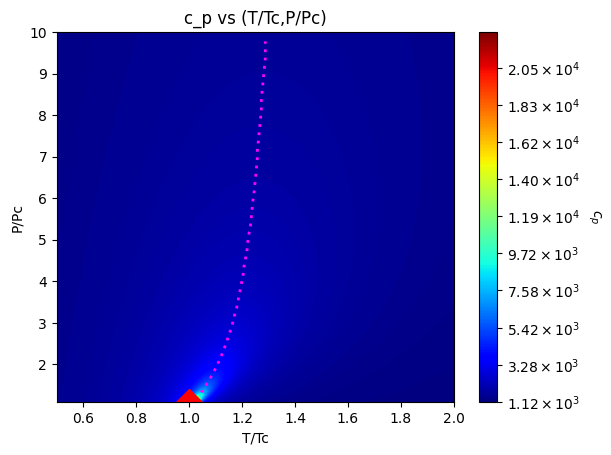

In [264]:
plot_c_p_array_PvsT(T_list_r, P_list_r, c_p_array, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=False, P_r_log_scale=False, c_p_log_scale=False, colormap='jet', nbr_of_contours=1000)

#### Colormaps of dimensionless numbers as a function of T/Tc and P/Pc

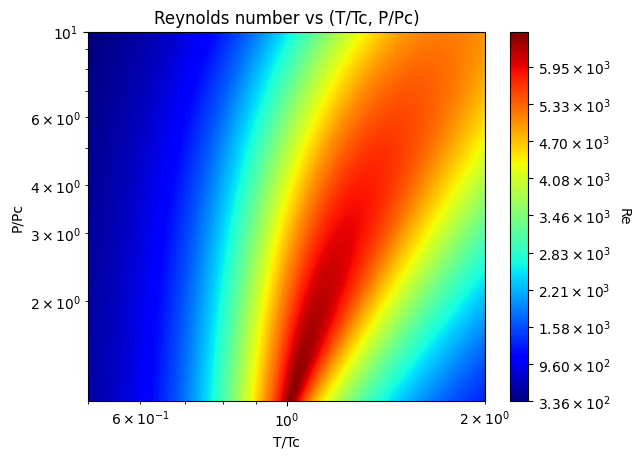

In [265]:
plot_Re_PvsT(T_list_r, P_list_r, Re_array, T_r_log_scale=True, P_r_log_scale=True, Re_log_scale=False, colormap='jet', nbr_of_contours=1000)

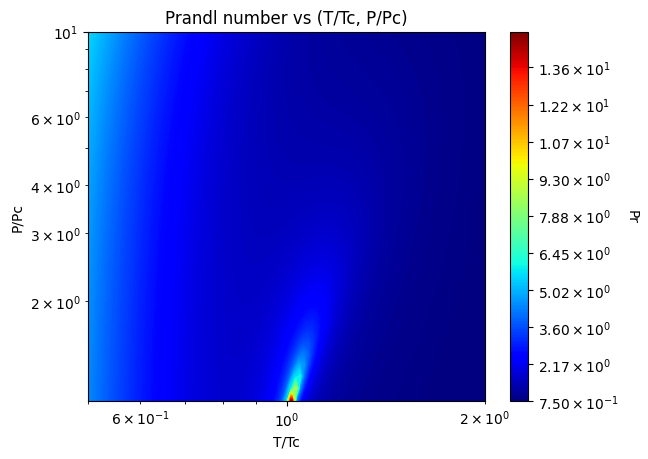

In [266]:
plot_Pr_PvsT(T_list_r, P_list_r, Pr_array, T_r_log_scale=True, P_r_log_scale=True, Pr_log_scale=False, colormap='jet', nbr_of_contours=1000)

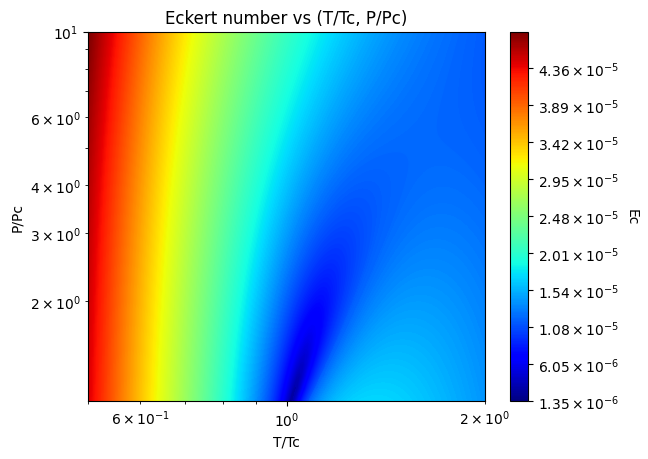

In [267]:
plot_Ec_PvsT(T_list_r, P_list_r, Ec_array, T_r_log_scale=True, P_r_log_scale=True, Ec_log_scale=False, colormap='jet', nbr_of_contours=1000)

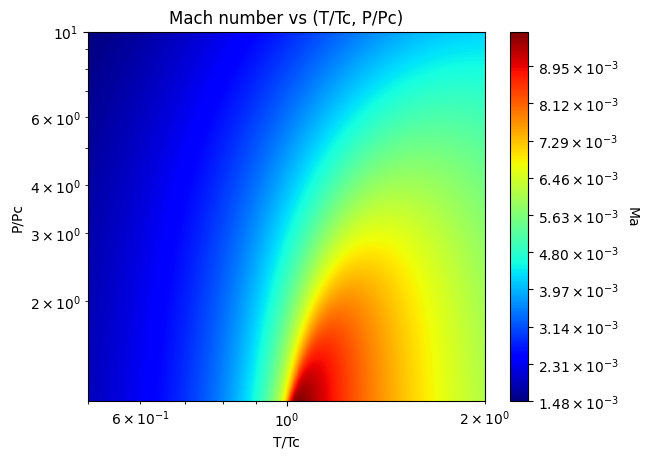

In [268]:
plot_Ma_PvsT(T_list_r, P_list_r, Ma_array, T_r_log_scale=True, P_r_log_scale=True, Ma_log_scale=False, colormap='jet', nbr_of_contours=1000)

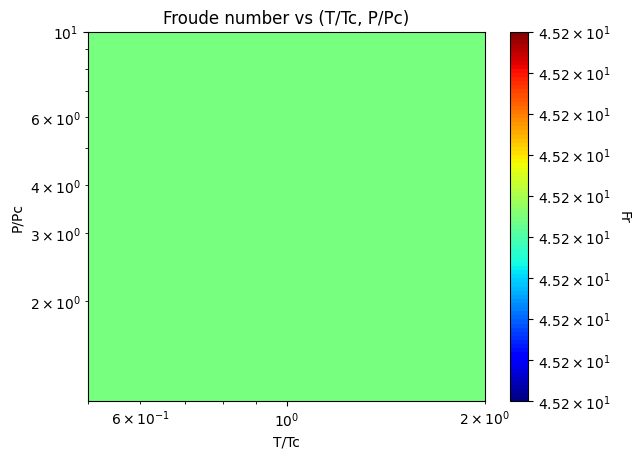

In [269]:
plot_Fr_PvsT(T_list_r, P_list_r, Fr_array, T_r_log_scale=True, P_r_log_scale=True, Fr_log_scale=False, colormap='jet', nbr_of_contours=100)

#### Colormaps of turbulent scales as a function of T/Tc and P/Pc

In [270]:
relative_spatial_resolution_limit=2e-3

In [271]:
plot_eta_star_PvsT(T_list_r, P_list_r, eta_star_array, relative_spatial_resolution_limit, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=False, P_r_log_scale=False, eta_star_log_scale=False, colormap='jet', nbr_of_contours=1000)

In [ ]:
relative_spatial_resolution_limit=5e-2

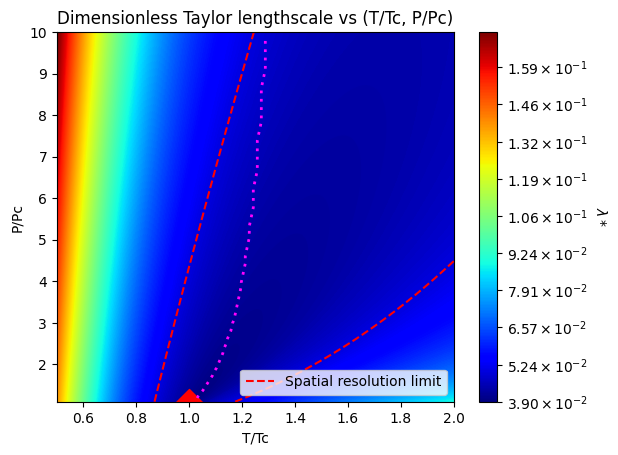

In [ ]:
plot_lambda_star_PvsT(T_list_r, P_list_r, lambda_star_array, relative_spatial_resolution_limit, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=False, P_r_log_scale=False, lambda_star_log_scale=False, colormap='jet', nbr_of_contours=1000)

In [ ]:
relative_temporal_resolution_limit=2e-2

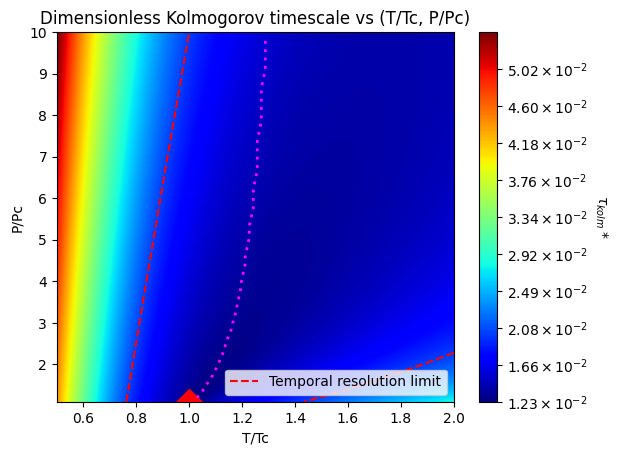

In [ ]:
plot_tau_kolm_star_array_PvsT(T_list_r, P_list_r, tau_kolm_star_array, relative_temporal_resolution_limit, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=False, P_r_log_scale=False, tau_kolm_star_log_scale=False, colormap='jet', nbr_of_contours=1000)

In [ ]:
relative_spatial_resolution_limit = 2e-3

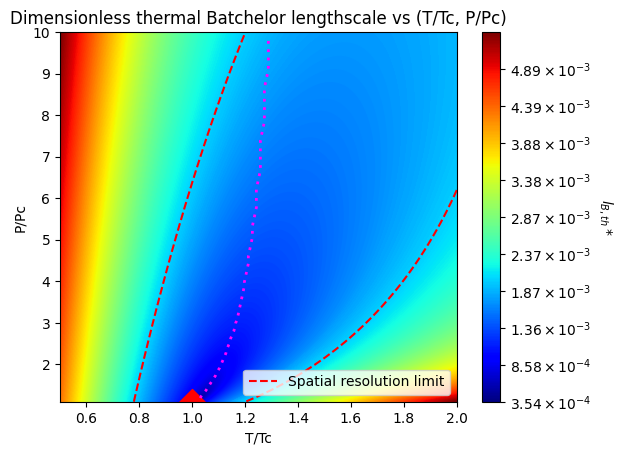

In [ ]:
plot_l_thermal_batchelor_star_array_PvsT(T_list_r, P_list_r, l_thermal_batchelor_star_array, relative_spatial_resolution_limit, pseudo_boiling_temperature_values, pseudo_boiling_pressure_values, T_r_log_scale=False, P_r_log_scale=False, l_thermal_batchelor_star_log_scale=False, colormap='jet', nbr_of_contours=1000)

# Notes

Max number of contour for contourf plot = 1000

# Test

In [ ]:
from matplotlib.colors import LogNorm

def plot_c_p_array_index(c_p_array):
    # Plot the image
    # Define the desired vmin and vmax values for the colorscale limits
    vmin = 2e3
    vmax = 2.5e3

    #plt.imshow(c_p_array, cmap='jet', vmin=vmin, vmax=vmax)
    plt.imshow(c_p_array, cmap='jet', norm=LogNorm(vmin=vmin, vmax=vmax))
    

    # Add a color bar
    plt.colorbar()


    # Add labels and title
    plt.xlabel('T/Tc index')
    plt.ylabel('P/Pc index')
    plt.title('c_p')

    # Display the plot
    plt.show()

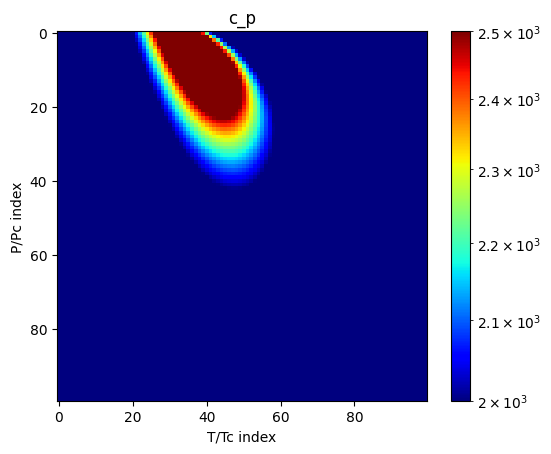

In [ ]:
plot_c_p_array_index(c_p_array)